In [10]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/TACTILEDRIVEN_ARTO/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
import tensorflow as tf
gpus = tensorflow.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
# Set GPU 1 (the second GPU) to be the only visible device
if gpus:
    try:
        tf.config.set_visible_devices(gpus[1], 'GPU')
        
        # Optionally, set memory growth to avoid allocating all memory on the GPU at once
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        print(e)


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rl_sim/TACTILEDRIVEN_ARTO/ML/DATA/1D_GRIPA_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=31)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=31)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 800  # Example sequence length
input_shape1 = (WS_B, 2)
input_shape2 = (WS_B, 2)
input_shape3 = (WS_B, 2)

data_dict = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test
}
def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = np.dstack((data[:, :, 0], data[:, :, 2]))
        globals()[f"{key}2"] = np.dstack((data[:, :, 0], data[:, :, 2]))
        globals()[f"{key}3"] = np.dstack((data[:, :, 6], data[:, :, 8]))
        # Uncomment and modify the line below if you need the fourth set
        # globals()[f"{key}4"] = np.dstack((data[:, :, 6], data[:, :, 8]))

assign_and_deploy_variables(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)

import tensorflow as tf
OUT_N = int(np.max(y_data))  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N+1))  # Generate labels from 0 to OUT_N+1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
X_data shape: (1465, 800, 9)
y_data shape: (1465,)
X_data.[0] shape:  (800, 9)
TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800, 9)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800, 9)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800, 9)    ||  Dimensions of y_val:   (293,)
Shapes of the stacked arrays:
X_train1 shape: (879, 800, 2)
X_train2 shape: (879, 800, 2)
X_train3 shape: (879, 800, 2)
OUT_N: 1
DISP_LABELS: [0, 1]


# 3ConvLayers FirstTry: FxFzTy + Tz + FyTx

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 80, 128)   │     10,368 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 80, 64)    │      5,184 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 80, 64)    │      5,184 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 37, 128)   │    131,200 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 37, 128)   │     65,664 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 37, 128)   │     65,664 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 37, 128)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 37, 128)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 37, 128)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 36, 256)   │     65,792 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 36, 128)   │     32,896 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 36, 128)   │     32,896 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 128)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 128)       │          0 │ conv1d_3_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ gap1d_1_1[0][0],  │
│ (Concatenate)       │                   │            │ gap1d_2_1[0][0],  │
│                     │                   │            │ gap1d_3_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     32,832 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │      1,040 │ dense_1[0][0]   

 Total params: 448,737 (1.71 MB)

 Trainable params: 448,737 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5528 - loss: 0.6833 - val_accuracy: 0.7031 - val_loss: 0.5973
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6480 - loss: 0.6006 - val_accuracy: 0.6758 - val_loss: 0.6349
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6422 - loss: 0.6189 - val_accuracy: 0.6655 - val_loss: 0.5839
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7110 - loss: 0.5507 - val_accuracy: 0.7270 - val_loss: 0.5284
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7217 - loss: 0.5289 - val_accuracy: 0.7645 - val_loss: 0.4299
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8085 - loss: 0.4341 - val_accuracy: 0.7850 - val_loss: 0.4148
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8049 - loss: 0.3775 - val_accuracy: 0.7474 - val_loss: 0.5695
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8338 - loss: 0.3613 - val_accuracy: 0.8396 - val_loss

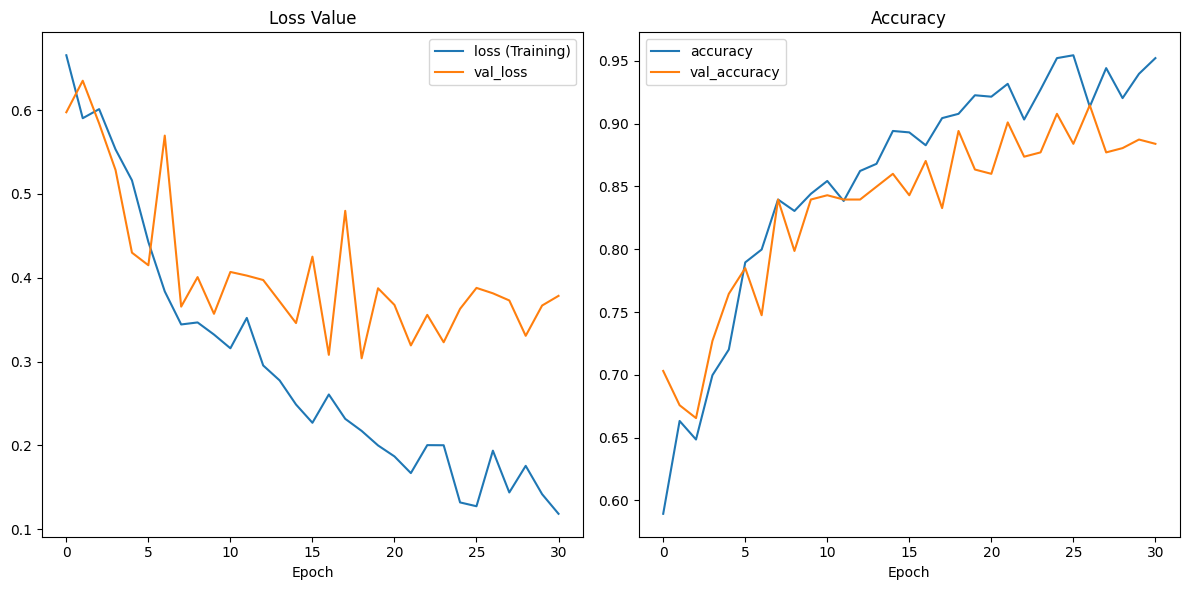

Test loss: 0.30001968145370483
Test accuracy: 0.8839590443686007
Accuracy Score: 0.8839590443686007
F1 Score: 0.8881578947368421
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.95      0.88       130
         1.0       0.96      0.83      0.89       163

    accuracy                           0.88       293
   macro avg       0.89      0.89      0.88       293
weighted avg       0.89      0.88      0.88       293



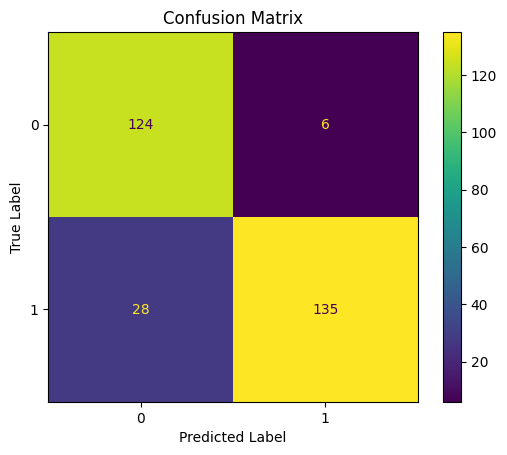

In [11]:
# Define the branched model
def build_branched_model1(input_shape1, input_shape2, input_shape3):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=128, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    # x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_1')(x1)
    x1 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    # x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    # x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Concatenate the outputs of the three branches
    merged = concatenate([x1, x2, x3], name='concatenate_1')
    
    # Dense layer
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='sigmoid', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3], outputs=output)
    return model

# Create and compile the model
model = build_branched_model1(input_shape1, input_shape2, input_shape3)
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit([X_train1, X_train2, X_train3], y_train, epochs=60, batch_size=32, validation_data=([X_val1, X_val2, X_val3], y_val), verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3])
y_pred_labels = (y_pred > 0.5).astype(int)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()


f1 = f1_score(y_test, y_pred_labels) 
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [12]:
# plot_grad_cam(model, [X_test1, X_test2, X_test3], 7, y_test, ['conv1d_1_3', 'conv1d_2_3', 'conv1d_3_3'])

# 3Conv 93% acheived

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 80, 128)   │     10,368 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 80, 64)    │      5,184 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 80, 64)    │      5,184 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 37, 128)   │    131,200 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 37, 128)   │     65,664 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 37, 128)   │     65,664 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 37, 128)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 37, 128)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 37, 128)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 36, 256)   │     65,792 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 36, 128)   │     32,896 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 36, 128)   │     32,896 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 128)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 128)       │          0 │ conv1d_3_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ gap1d_1_1[0][0],  │
│ (Concatenate)       │                   │            │ gap1d_2_1[0][0],  │
│                     │                   │            │ gap1d_3_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │      2,064 │ dense_1[0][0]   

 Total params: 482,593 (1.84 MB)

 Trainable params: 482,593 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5058 - loss: 0.6958 - val_accuracy: 0.7304 - val_loss: 0.6227
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 0.6105 - val_accuracy: 0.6928 - val_loss: 0.5751
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7227 - loss: 0.5488 - val_accuracy: 0.7270 - val_loss: 0.5189
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7365 - loss: 0.4922 - val_accuracy: 0.7406 - val_loss: 0.4731
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7140 - loss: 0.5124 - val_accuracy: 0.7679 - val_loss: 0.4285
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7618 - loss: 0.4451 - val_accuracy: 0.7918 - val_loss: 0.4196
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7635 - loss: 0.4680 - val_accuracy: 0.7850 - val_loss: 0.3968
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8488 - loss: 0.3473 - val_accuracy: 0.8567 - val_loss

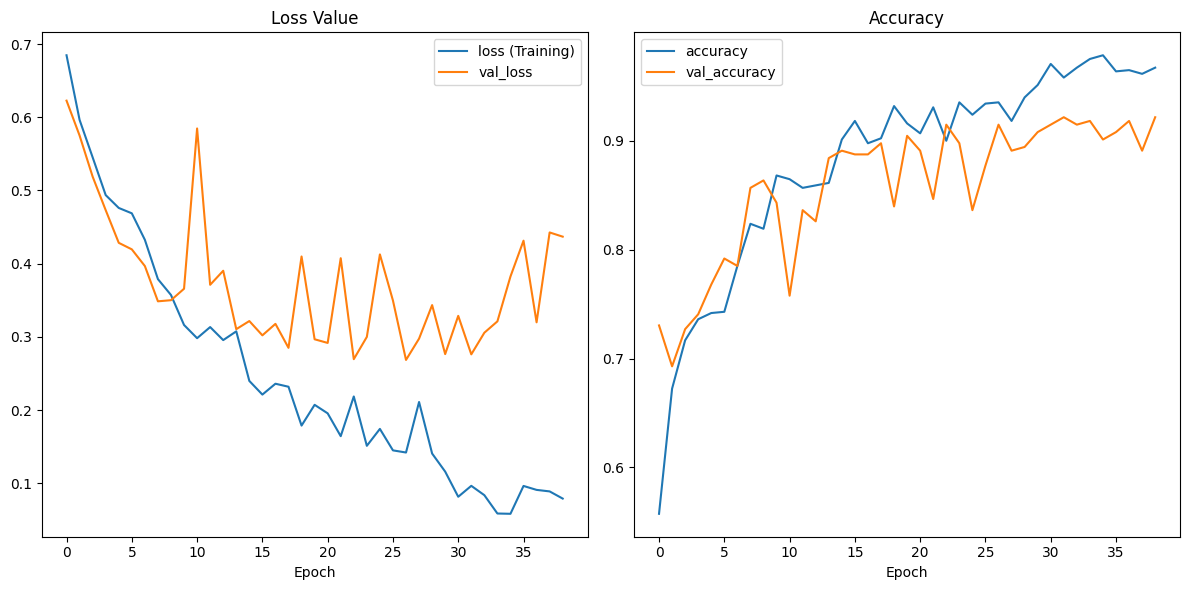

Test loss: 0.29968732595443726
Test accuracy: 0.9010238907849829
Accuracy Score: 0.9010238907849829
F1 Score: 0.9061488673139159
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.95      0.90       130
         1.0       0.96      0.86      0.91       163

    accuracy                           0.90       293
   macro avg       0.90      0.91      0.90       293
weighted avg       0.91      0.90      0.90       293



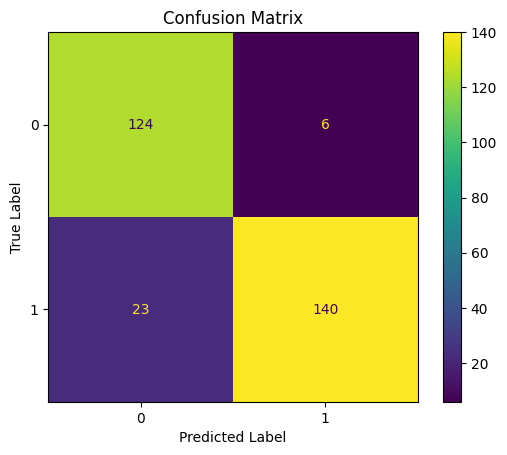

In [13]:
def build_branched_model2(input_shape1, input_shape2, input_shape3):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=128, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    #x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_1')(x1)
    x1 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    #x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    #x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Concatenate the outputs of the three branches
    merged = concatenate([x1, x2, x3], name='concatenate_1')
    
    # Dense layer
    dense = Dense(128, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='sigmoid', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3], outputs=output)
    return model

# Create and compile the model
model = build_branched_model2(input_shape1, input_shape2, input_shape3)
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit([X_train1, X_train2, X_train3], y_train, epochs=60, batch_size=32, validation_data=([X_val1, X_val2, X_val3], y_val), verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3])
y_pred_labels = (y_pred > 0.5).astype(int)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()


f1 = f1_score(y_test, y_pred_labels) 
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# 4 ConvLayers

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_0 (Conv1D) │ (None, 80, 128)   │     25,728 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_0 (Conv1D) │ (None, 80, 64)    │     12,864 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_0 (Conv1D) │ (None, 80, 64)    │     12,864 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 19, 128)   │    131,200 │ conv1d_1_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 19, 128)   │     65,664 │ conv1d_2_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 19, 128)   │     65,664 │ conv1d_3_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 6, 256)    │    262,400 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 6, 128)    │    131,200 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 6, 128)    │    131,200 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 6, 256)    │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 6, 128)    │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 6, 128)    │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 5, 512)    │    262,656 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 5, 128)    │     32,896 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 5, 128)    │     32,896 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 512)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 128)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 128)       │          0 │ conv1d_3_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 768)       │          0 │ gap1d_1_1[0][0],

 Total params: 1,267,745 (4.84 MB)

 Trainable params: 1,267,745 (4.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5288 - loss: 0.6826 - val_accuracy: 0.6724 - val_loss: 0.5850
Epoch 2/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6382 - loss: 0.5783 - val_accuracy: 0.7338 - val_loss: 0.5074
Epoch 3/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7453 - loss: 0.4961 - val_accuracy: 0.7543 - val_loss: 0.4842
Epoch 4/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7603 - loss: 0.4593 - val_accuracy: 0.7201 - val_loss: 0.5399
Epoch 5/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7239 - loss: 0.5276 - val_accuracy: 0.7952 - val_loss: 0.4106
Epoch 6/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8139 - loss: 0.4108 - val_accuracy: 0.7952 - val_loss: 0.5012
Epoch 7/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8095 - loss: 0.3930 - val_accuracy: 0.8225 - val_loss: 0.3895
Epoch 8/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8267 - loss: 0.3724 - val_accuracy: 0.8259 - val_loss

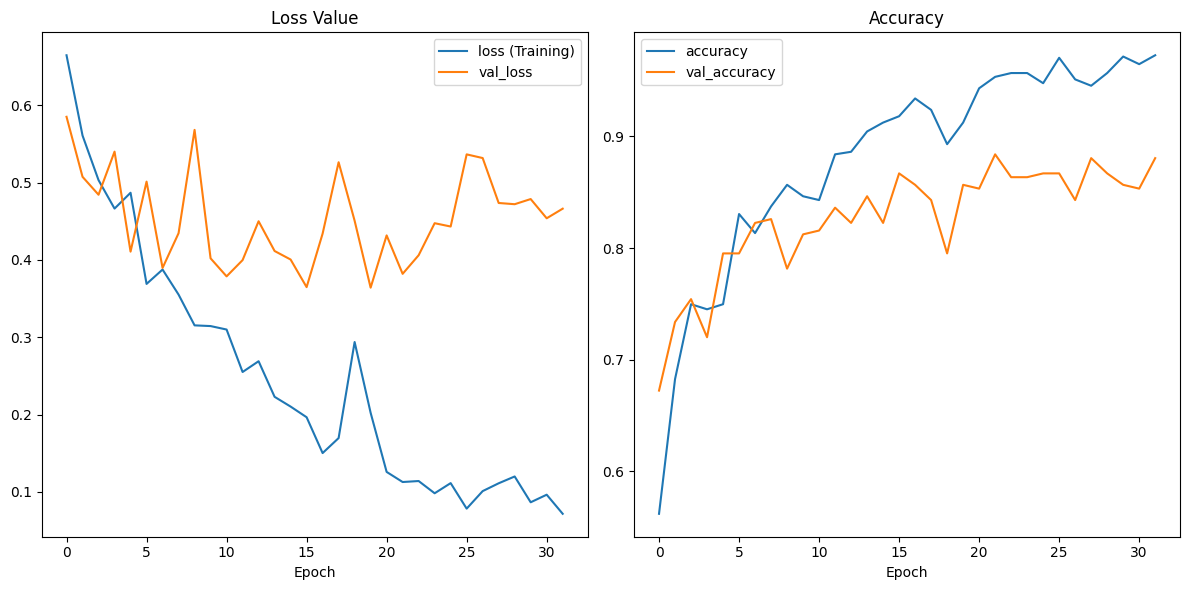

Test loss: 0.2790251076221466
Test accuracy: 0.8805460750853242
Accuracy Score: 0.8805460750853242
F1 Score: 0.8909657320872274
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.88      0.87       130
         1.0       0.91      0.88      0.89       163

    accuracy                           0.88       293
   macro avg       0.88      0.88      0.88       293
weighted avg       0.88      0.88      0.88       293



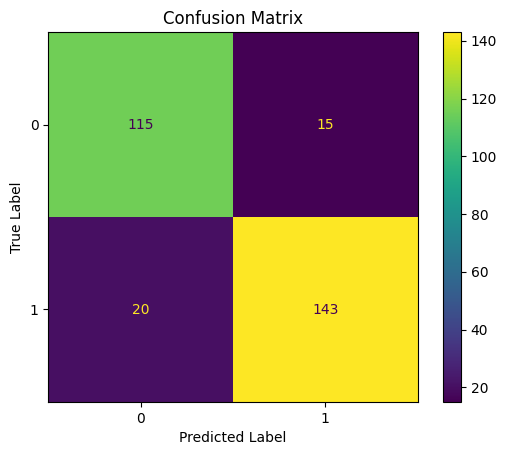

In [14]:
def build_branched_model3(input_shape1, input_shape2, input_shape3):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=128, kernel_size=100, strides=10, activation='relu', padding='same', name='conv1d_1_0')(input1)
    x1 = Conv1D(filters=128, kernel_size=8, strides=4, activation='relu', name='conv1d_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.3, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=512, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)

    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64, kernel_size=100, strides=10, activation='relu', padding='same', name='conv1d_2_0')(input2)
    x2 = Conv1D(filters=128, kernel_size=8, strides=4, activation='relu', name='conv1d_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.3, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)

    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64, kernel_size=100, strides=10, activation='relu', padding='same', name='conv1d_3_0')(input3)
    x3 = Conv1D(filters=128, kernel_size=8, strides=4, activation='relu', name='conv1d_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.3, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)

    # Concatenate the outputs of the three branches
    merged = concatenate([x1, x2, x3], name='concatenate_1')

    # Dense layers
    dense = Dense(128, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)

    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='sigmoid', name='output')(dense)

    # Create the model
    model = Model(inputs=[input1, input2, input3], outputs=output)

    return model


# Create and compile the model
model = build_branched_model3(input_shape1, input_shape2, input_shape3)
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit([X_train1, X_train2, X_train3], y_train, epochs=70, batch_size=32, validation_data=([X_val1, X_val2, X_val3], y_val), verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3])
y_pred_labels = (y_pred > 0.5).astype(int)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()


f1 = f1_score(y_test, y_pred_labels) 
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# EASY MODEL (98%) ADAPTED FOR GRADCAM + NAMES

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 96, 128)   │     10,368 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 799, 128)  │        640 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_1_1       │ (None, 48, 128)   │          0 │ conv1d_1_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_2_1       │ (None, 399, 128)  │          0 │ conv1d_2_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 15, 128)   │    327,808 │ maxpool1d_1_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 196, 64)   │     65,600 │ maxpool1d_2_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 800, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_1_2       │ (None, 7, 128)    │          0 │ conv1d_1_2[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_2_2       │ (None, 98, 64)    │          0 │ conv1d_2_2[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 77, 64)    │      5,184 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 4, 256)    │    131,328 │ maxpool1d_1_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 95, 128)   │     32,896 │ maxpool1d_2_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_3_1       │ (None, 38, 64)    │          0 │ conv1d_3_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ globalmaxpool1d_1_1 │ (None, 256)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_4 (Conv1D) │ (None, 94, 64)    │     16,448 │ conv1d_2_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 29, 64)    │     41,024 │ maxpool1d_3_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1_1 (Dense)   │ (None, 128)       │     32,896 │ globalmaxpool1d_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ globalmaxpool1d_2_1 │ (None, 64)        │          0 │ conv1d_2_4[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_3_2       │ (None, 14, 64)    │          0 │ conv1d_3_2[0][0]  │
│ (MaxPooling1D)      │                   │            │                 

 Total params: 715,681 (2.73 MB)

 Trainable params: 715,681 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.5442 - loss: 0.6815 - val_accuracy: 0.7235 - val_loss: 0.4978
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7371 - loss: 0.5227 - val_accuracy: 0.7645 - val_loss: 0.4589
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7766 - loss: 0.4776 - val_accuracy: 0.7952 - val_loss: 0.4176
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8121 - loss: 0.4002 - val_accuracy: 0.8294 - val_loss: 0.3788
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8289 - loss: 0.3774 - val_accuracy: 0.8328 - val_loss: 0.3482
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.2857 - val_accuracy: 0.8498 - val_loss: 0.3564
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8721 - loss: 0.3004 - val_accuracy: 0.8601 - val_loss: 0.3298
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8434 - loss: 0.3013 - val_accuracy: 0.8601 - val_loss

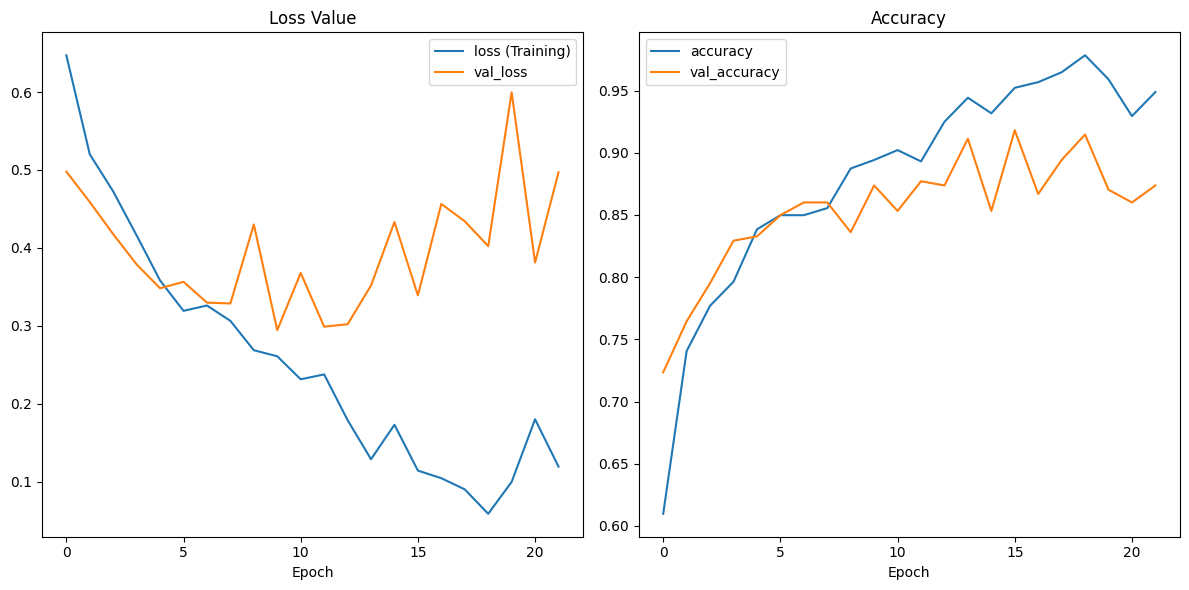

Test loss: 0.26785510778427124
Test accuracy: 0.9010238907849829
Accuracy Score: 0.9010238907849829
F1 Score: 0.9113149847094801
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.88      0.89       130
         1.0       0.91      0.91      0.91       163

    accuracy                           0.90       293
   macro avg       0.90      0.90      0.90       293
weighted avg       0.90      0.90      0.90       293



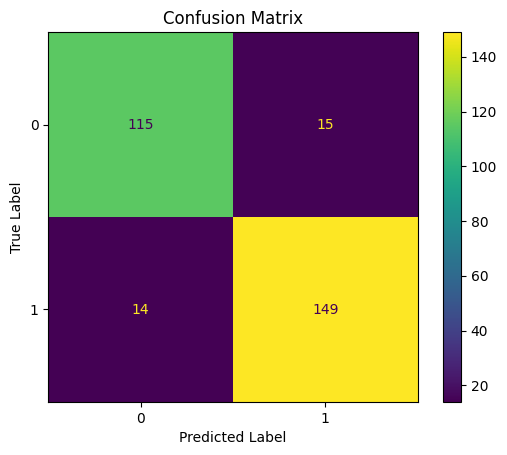

In [15]:
def build_SeparatedEASYmodel(input_shape1, input_shape2, input_shape3):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(128, kernel_size=40, strides=8, activation='relu', name='conv1d_1_1')(input1)
    x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_1')(x1)
    x1 = Conv1D(128, kernel_size=20, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_2')(x1)
    x1 = Conv1D(256, kernel_size=4, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='globalmaxpool1d_1_1')(x1)
    x1 = Dense(128, activation='relu', name='dense_1_1')(x1)
    x1 = Dropout(0.2, name='dropout_1_1')(x1)
    out1 = Dense(64, activation='relu', name='dense_1_2')(x1)

    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(128, kernel_size=2, activation='relu', name='conv1d_2_1')(input2)
    x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_1')(x2)
    x2 = Conv1D(64, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_2')(x2)
    x2 = Conv1D(128, kernel_size=4, activation='relu', name='conv1d_2_3')(x2)
    x2 = Conv1D(64, kernel_size=2, activation='relu', name='conv1d_2_4')(x2)
    x2 = GlobalMaxPooling1D(name='globalmaxpool1d_2_1')(x2)
    x2 = Dropout(0.1, name='dropout_2_1')(x2)
    out2 = Dense(64, activation='relu', name='dense_2_1')(x2)

    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(64, kernel_size=40, strides=10, activation='relu', name='conv1d_3_1')(input3)
    x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_1')(x3)
    x3 = Conv1D(64, kernel_size=10, activation='relu', name='conv1d_3_2')(x3)
    x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_2')(x3)
    x3 = Flatten(name='flatten_3_1')(x3)
    out3 = Dense(32, activation='relu', name='dense_3_1')(x3)

    # Concatenate the outputs of the branches
    merged = concatenate([out1, out2, out3], name='concatenate_1')
    merged = Dropout(0.2, name='dropout_merged')(merged)
    merged = Dense(64, activation='relu', name='dense_merged_1')(merged)
    output = Dense(1, activation='sigmoid', name='output')(merged)

    # Create the model
    separated_model = Model(inputs=[input1, input2, input3], outputs=output)

    return separated_model

# Create and compile the model
model = build_SeparatedEASYmodel(input_shape1, input_shape2, input_shape3)
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit([X_train1, X_train2, X_train3], y_train, epochs=50, batch_size=32, validation_data=([X_val1, X_val2, X_val3], y_val), verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3])
y_pred_labels = (y_pred > 0.5).astype(int)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()


f1 = f1_score(y_test, y_pred_labels) 
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# model_name = "1DComb3_NotNorm_Butt_3plusConv_FullMaxPool_ManyDens_95"
# from ML_models_functions import save_datasummary_and_results
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_SeparatedEASYmodel, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

In [17]:
# plot_grad_cam(model, [X_test1, X_test2, X_test3], 8, y_test, ['conv1d_1_3', 'conv1d_2_4', 'conv1d_3_2'])